***PREVISÃO DE PREÇOS DE AÇÕES COM XGBOOST E RECOMENDAÇÕES AUTOMÁTICAS DE COMPRA E VENDAS PARA CLIENTES***

-Uso da biblioteca XGBoost para prever preços futuros da PETR4 usando indicadores técnicos como features, criei um modelo que pode ser usado em qualquer ação.

-O Gradient Boosting é um exemplo popular de técnica de boosting, onde cada nova árvore de decisão é treinada para se concentrar nos exemplos que foram mal previstos pelas árvores anteriores.

-Escolhi as açoes por dois motivos, o primeiro motivo é que o dataframe esta completo e o segundo motivo é o nível de dificuldade de prever series temporais com dados desconhecidos. Se a acuracia desse modelo for razoável, a tendência é que em outros modelos a mesma performe melhor.

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/petr4-20y/petr4.csv
/kaggle/input/ibovibov/ibov.csv
/kaggle/input/h1commedias/h1commedias.csv


In [2]:
#Leitura do datasete retirada do datetime
data = pd.read_csv("/kaggle/input/petr4-20y/petr4.csv")

#retirada da coluna volume por estar imcompleta 
data = data.drop(data.columns[[5]],axis=1)
print(data)


            Date       Open       High        Low      Close    Volume
0     2003-08-25   7.250000   7.275000   7.126250   7.140000  20569600
1     2003-08-26   7.168750   7.250000   7.093750   7.212500  35600000
2     2003-08-27   7.250000   7.406250   7.225000   7.406250  31596800
3     2003-08-28   7.407500   7.487500   7.337500   7.406250  32864000
4     2003-08-29   7.312500   7.610000   7.286250   7.600000  42502400
...          ...        ...        ...        ...        ...       ...
4987  2023-08-21  31.700001  32.029999  30.969999  31.299999  42236900
4988  2023-08-22  30.500000  30.610001  30.240000  30.610001  31372200
4989  2023-08-23  31.200001  32.240002  31.090000  32.240002  95507400
4990  2023-08-24  32.270000  32.720001  31.840000  32.189999  49332300
4991  2023-08-25  32.380001  32.470001  31.799999  31.969999  33989200

[4992 rows x 6 columns]


# Definir as médias móveis

In [3]:
data['media_21'] = data['Close'].ewm(21).mean().shift()

data['media_9'] = data['Close'].ewm(9).mean().shift()



# Definir a função RSI (índice de forçã relativa)

In [4]:
def relative_strength_idx(df, n=14):
    Close = df['Close'] 
    delta = Close.diff()
    delta = delta.iloc[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

data['RSI'] = relative_strength_idx(data).fillna(0)
data = data[data['RSI'].notna() & (data['RSI'] != 0)]

data

,Date,Open,High,Low,Close,Volume,media_21,media_9,RSI
14,2003-09-12,8.000000,8.105000,7.937500,8.037500,36400000,7.730696,7.792598,78.628412
15,2003-09-15,8.037500,8.087500,7.825000,7.862500,54713600,7.758458,7.823438,69.461085
16,2003-09-16,7.912500,7.961250,7.856250,7.906250,29587200,7.767467,7.828233,66.447374
17,2003-09-17,7.937500,7.937500,7.800000,7.875000,38595200,7.779009,7.837596,65.108788
18,2003-09-18,7.875000,7.937500,7.806250,7.887500,43830400,7.786703,7.841997,60.492702
...,...,...,...,...,...,...,...,...,...
4987,2023-08-21,31.700001,32.029999,30.969999,31.299999,42236900,29.983140,30.651353,60.115587
4988,2023-08-22,30.500000,30.610001,30.240000,30.610001,31372200,30.042998,30.716218,50.980391
4989,2023-08-23,31.200001,32.240002,31.090000,32.240002,95507400,30.068770,30.705596,62.406026
4990,2023-08-24,32.270000,32.720001,31.840000,32.189999,49332300,30.167463,30.859036,74.606701


# PLOTAGEM DO GRAFICO E DO RSI

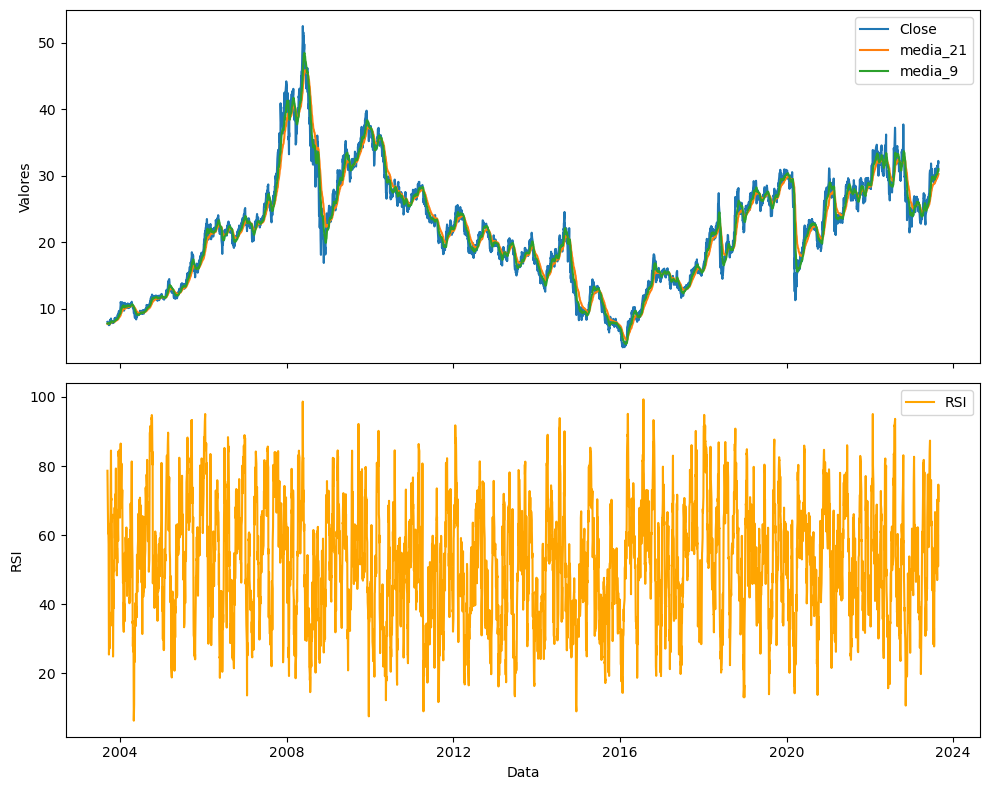

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"])

# Plotar os gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico principal
ax1.plot(df["Date"], df["Close"], label="Close")
ax1.plot(df["Date"], df["media_21"], label="media_21")
ax1.plot(df["Date"], df["media_9"], label="media_9")
ax1.set_ylabel("Valores")
ax1.legend()

# Gráfico para RSI
ax2.plot(df["Date"], df["RSI"], label="RSI", color="orange")
ax2.set_xlabel("Data")
ax2.set_ylabel("RSI")
ax2.legend()

# Ajustes de layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

# Retirada da coluna Date

# INCLUSÃO DO MACD

In [6]:
media_12 = pd.Series(data['Close'].ewm(span=12, min_periods=12).mean())
media_26 = pd.Series(data['Close'].ewm(span=26, min_periods=26).mean())
data['MACD'] = pd.Series(media_12 - media_26)
data['MACD_signal'] = pd.Series(data.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data.Date, y=data.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.Date, y=media_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.Date, y=media_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.Date, y=data['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.Date, y=data['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [7]:
data.describe()

,Open,High,Low,Close,Volume,media_21,media_9,RSI,MACD,MACD_signal
count,4971.000000,4971.000000,4971.000000,4971.000000,4.971000e+03,4971.000000,4971.000000,4971.000000,4946.000000,4938.000000
mean,21.739979,22.058256,21.397056,21.721793,5.020265e+07,21.619564,21.672649,52.372217,0.031732,0.031402
std,8.353814,8.461530,8.231336,8.347714,7.242584e+07,8.157194,8.259084,17.212637,0.668955,0.628783
min,4.200000,4.270000,4.120000,4.200000,0.000000e+00,5.269669,4.689682,6.329113,-4.419218,-3.888651
25%,15.405000,15.655000,15.110000,15.385000,2.101390e+07,15.409807,15.508582,39.143066,-0.289531,-0.268363
50%,21.850000,22.129999,21.510000,21.760000,3.523150e+07,21.614100,21.717950,52.462699,0.075749,0.077854
75%,27.299999,27.629999,26.905000,27.270000,5.682330e+07,27.145597,27.208448,64.905023,0.421269,0.400970
max,52.580002,53.680000,51.950001,52.509998,1.336049e+09,45.891425,48.473556,99.280593,2.669063,2.334861


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4971 entries, 14 to 4991
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4971 non-null   datetime64[ns]
 1   Open         4971 non-null   float64       
 2   High         4971 non-null   float64       
 3   Low          4971 non-null   float64       
 4   Close        4971 non-null   float64       
 5   Volume       4971 non-null   int64         
 6   media_21     4971 non-null   float64       
 7   media_9      4971 non-null   float64       
 8   RSI          4971 non-null   float64       
 9   MACD         4946 non-null   float64       
 10  MACD_signal  4938 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 466.0 KB


# RETIRADA DA COLUNA DATE

In [9]:
# Criar uma cópia da coluna "Date"
data_index = data['Date'].copy()

# Remover a coluna "Date" do DataFrame
data.drop('Date', axis=1, inplace=True)

data.index = data_index

# RETIRADA DE DADOS NAN DA LINHAS

In [10]:
data.dropna(axis=0, how="any", inplace=True)
data

,Open,High,Low,Close,Volume,media_21,media_9,RSI,MACD,MACD_signal
Date,,,,,,,,,,
2003-10-29,8.155000,8.246250,8.037500,8.037500,43200000,7.998883,8.053002,39.819000,0.002734,0.017266
2003-10-30,8.062500,8.125000,7.876250,7.938750,31206400,8.000849,8.051442,37.288119,-0.006065,0.012039
2003-10-31,8.000000,8.061250,7.875000,7.875000,43961600,7.997705,8.040108,24.881284,-0.017671,0.005538
2003-11-03,7.931250,8.112500,7.931250,8.112500,36051200,7.991524,8.023511,40.393203,-0.008610,0.002500
2003-11-04,8.118750,8.312500,8.025000,8.080000,45190400,7.997588,8.032452,46.985438,-0.003886,0.001148
...,...,...,...,...,...,...,...,...,...,...
2023-08-21,31.700001,32.029999,30.969999,31.299999,42236900,29.983140,30.651353,60.115587,0.421608,0.349877
2023-08-22,30.500000,30.610001,30.240000,30.610001,31372200,30.042998,30.716218,50.980391,0.363718,0.352645
2023-08-23,31.200001,32.240002,31.090000,32.240002,95507400,30.068770,30.705596,62.406026,0.444245,0.370965


# CORRELAÇÃO

In [11]:
data.corr()

,Open,High,Low,Close,Volume,media_21,media_9,RSI,MACD,MACD_signal
Open,1.000000,0.999281,0.999067,0.998304,-0.033789,0.973387,0.988002,0.072227,0.200982,0.213506
High,0.999281,1.000000,0.998769,0.999121,-0.029935,0.974032,0.988133,0.074639,0.197798,0.209555
Low,0.999067,0.998769,1.000000,0.999178,-0.039551,0.970928,0.986039,0.082249,0.208330,0.218084
Close,0.998304,0.999121,0.999178,1.000000,-0.034615,0.971738,0.986312,0.084701,0.204509,0.213972
Volume,-0.033789,-0.029935,-0.039551,-0.034615,1.000000,-0.019306,-0.023805,-0.030772,-0.052611,-0.044859
media_21,0.973387,0.974032,0.970928,0.971738,-0.019306,1.000000,0.994323,-0.084747,-0.015878,0.018971
media_9,0.988002,0.988133,0.986039,0.986312,-0.023805,0.994323,1.000000,-0.041660,0.079801,0.122111
RSI,0.072227,0.074639,0.082249,0.084701,-0.030772,-0.084747,-0.041660,1.000000,0.641336,0.467507
MACD,0.200982,0.197798,0.208330,0.204509,-0.052611,-0.015878,0.079801,0.641336,1.000000,0.951861
MACD_signal,0.213506,0.209555,0.218084,0.213972,-0.044859,0.018971,0.122111,0.467507,0.951861,1.000000


# RETIRANDO A ULTIMA LINHA PARA FAZER A PREVISÃO NO FUTURO

In [12]:
future_data = data.iloc[-1:]
data = data.drop(data.index[-1:])

# SEPARANDO AS FEATURES DO TARGET

In [13]:
X = data.drop("Close", axis=1)
y = data['Close']

# Dividir os dados em treinamento (80%) e validação (20%)

In [14]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Configuração da validação cruzada
processo de K-Fold Cross-Validation envolve dividir o conjunto de dados em K partes (ou "dobras") aproximadamente iguais. O modelo é então treinado e avaliado K vezes, usando K-1 partes como conjunto de treinamento e a parte restante como conjunto de validação. Em cada iteração, uma parte diferente é usada como conjunto de validação, garantindo que cada parte do conjunto de dados tenha a chance de ser usada para avaliação.

In [15]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Parâmetros para busca de hiperparâmetros
*Usei parametros com baixo número de estimadores (ou árvores) no ensemble, somente para demonstração, mas fique a vontade para alterar os parametros.*

In [54]:
parameters = {
    'n_estimators': [ 5000],
    'learning_rate': [ 0.03],
    'max_depth': [6],
    'gamma': [0.02],
    'subsample': [0.75],
    'colsample_bynode': [0.5],
    'random_state': [42]
}

# Modelo base para XGBoost

In [56]:
base_model = XGBRegressor(
    booster="gbtree",
    objective='reg:squarederror'
)

# Criar o objeto GridSearchCV

In [57]:
clf = GridSearchCV(base_model, parameters, cv=kf)

# Treinar o modelo com a busca de hiperparâmetros

In [58]:
clf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    i...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bynode': [0.5], 'gamma': [0.02],
                         'learning_rate': [0.03], 'max_depth': [6],
                         'n_estimators': [5000], 'random_state': [42],
                         'subsample': [0.75]})

# Imprimir os melhores parâmetros e o melhor score

In [59]:
print(f'Melhores parametros: {clf.best_params_}')
print(f'melhor validação = {clf.best_score_}')

Melhores parametros: {'colsample_bynode': 0.5, 'gamma': 0.02, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 5000, 'random_state': 42, 'subsample': 0.75}
melhor validação = 0.9987733794525557


# Calcular e imprimir o mean_squared_error para os dados de treinamento e validação

In [60]:
y_pred_train = clf.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'mean_squared_error (Training) = {mse_train}')


y_pred_val = clf.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f'mean_squared_error (Validation) = {mse_val}')

mean_squared_error (Training) = 0.0026258494350265434
mean_squared_error (Validation) = 0.002815101598314278


# Fazer previsões para os próximos 1 ponto no futuro

In [61]:
future_close_pred = clf.predict(future_data.drop("Close", axis=1))
print(f'Previsão de valor do dia seguinte: {future_close_pred}')

Previsão de valor do dia seguinte: [32.157494]


# Salvar o modelo treinado em um arquivo

In [62]:
import joblib
model_filename = 'xgboost_model.pkl'
joblib.dump(clf, model_filename)
print(f'modelo salvo {model_filename}')

modelo salvo xgboost_model.pkl


# Plotar a importância das features do melhor modelo encontrado

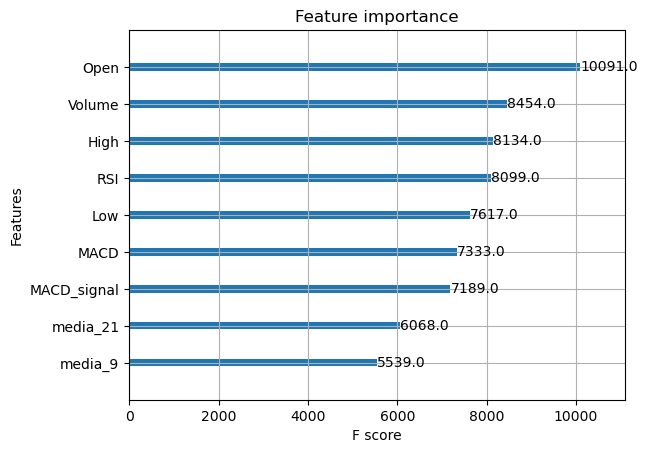

In [78]:
from xgboost import plot_importance

best_model = clf.best_estimator_
plot_importance(best_model)
plt.show()


# Comparação da previsão e a diferença entre as colunas

In [75]:
previsão = pd.DataFrame(index=data.index)
previsão['Close_Real'] = data['Close']
previsão['Previsão'] = clf.predict(X)


previsão.loc[future_data.index[0], 'Previsão'] = future_close_pred
previsão['Diferença'] = previsão['Previsão'] - previsão['Close_Real']

print(previsão)


            Close_Real   Previsão  Diferença
Date                                        
2003-10-29    8.037500   8.038877   0.001376
2003-10-30    7.938750   7.944570   0.005820
2003-10-31    7.875000   7.869820  -0.005180
2003-11-03    8.112500   8.059573  -0.052927
2003-11-04    8.080000   8.072927  -0.007073
...                ...        ...        ...
2023-08-21   31.299999  31.361898   0.061899
2023-08-22   30.610001  30.510895  -0.099106
2023-08-23   32.240002  32.219006  -0.020996
2023-08-24   32.189999  32.238350   0.048351
2023-08-25         NaN  32.157494        NaN

[4938 rows x 3 columns]


# Plotagem do resultado da previsão

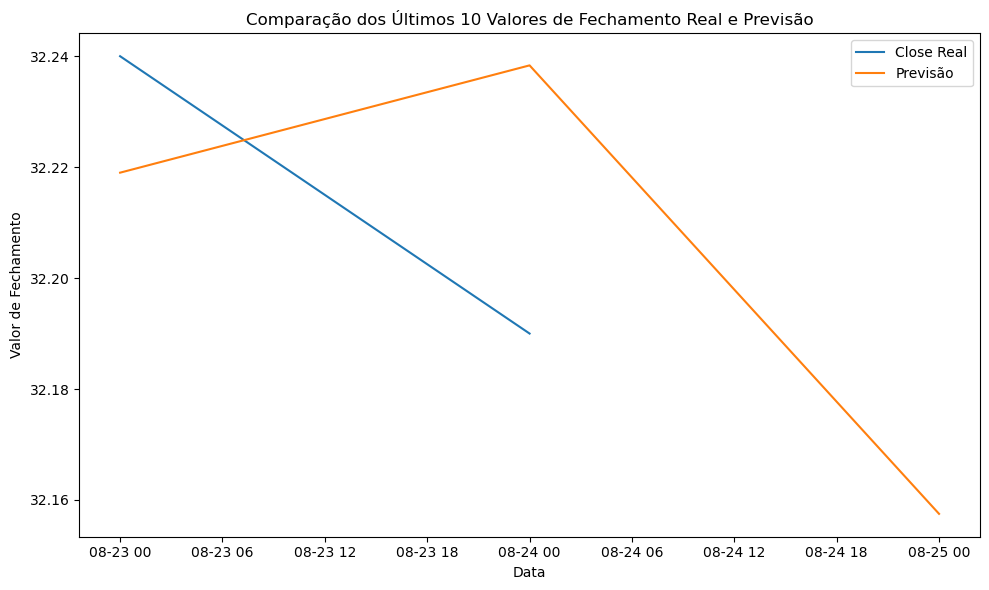

In [73]:
prev_do_dia = predictions_df.tail(3)

# Plotar os valores reais de fechamento e as previsões
plt.figure(figsize=(10, 6))
plt.plot(prev_do_dia.index, prev_do_dia['Close_Real'], label='Close Real')
plt.plot(prev_do_dia.index, prev_do_dia['Previsão'], label='Previsão')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.title('Comparação dos Últimos 10 Valores de Fechamento Real e Previsão')
plt.legend()
plt.tight_layout()
plt.show()

# O XGBOOST é um ótimo algoritmo de aprendizado de máquina baseado em árvores de decisão, porém não considero ele melhor do que o LSTM para prever sequências temporais.

OBS: Acertou a previsão de fechamento do dia 25/08/2023 para petr4.